In [15]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr

uploaded = files.upload()
df = pd.read_excel('202501_clean2.xlsx')

Saving 202501_clean2.xlsx to 202501_clean2 (2).xlsx


In [16]:
# 금속 컬럼 추출
unit_patterns = ['(ng/m3)', '(ug/m3)', '(µg/m³)', '(μg/m3)']
columns_to_analyze = [c for c in df.columns if any(p in str(c) for p in unit_patterns)]

# X축 추출
x_candidates = ['Conc(ug/m3)', 'PM2.5(ug/m3)', 'PM2.5 (ug/m3)', 'Con(ug/m3)']
xcol = next((c for c in x_candidates if c in df.columns), None)
if xcol is None:
    raise ValueError("X-axis column not found. Check the actual column name for PM2.5 mass (e.g., 'Conc(ug/m3)' or 'PM2.5(ug/m3)').")

# Y축 추출
ycols = [c for c in columns_to_analyze if c != xcol]
if len(ycols) == 0:
    raise ValueError("No Y columns to plot. Check filter logic for columns_to_analyze.")

# 농도 수치화, 음수값 제거
def clean_series(s: pd.Series) -> pd.Series:
    s_num = pd.to_numeric(s, errors='coerce')
    return s.mask(s < 0)

In [18]:
# 산점도 및 회귀선 그리기
def plot_scatter_with_regression(x: str, y: str, data: pd.DataFrame, ax):
    # 숫자화, 정리 후 결측 제거
    x_ser = clean_series(data[x])
    y_ser = clean_series(data[y])
    df_xy = pd.concat([x_ser.rename(x), y_ser.rename(y)], axis=1).dropna()

    # 표본 부족, 분산 0 예외 처리
    if len(df_xy) < 3 or df_xy[x].std() == 0 or df_xy[y].std() == 0:
        sns.scatterplot(data=df_xy, x=x, y=y, ax=ax, s=20, alpha=0.7, edgecolor=None)
        ax.set_xlabel(x); ax.set_ylabel(y)
        ax.set_title(f"Scatter: {x} vs {y}\nInsufficient or constant data")
        return None

    # 산점도
    sns.scatterplot(data=df_xy, x=x, y=y, ax=ax, s=20, alpha=0.7, edgecolor=None)

    # 선형회귀
    X_vals = df_xy[[x]].to_numpy()
    y_vals = df_xy[y].to_numpy()
    model = LinearRegression().fit(X_vals, y_vals)
    y_pred = model.predict(X_vals)
    r2 = float(model.score(X_vals, y_vals))
    slope = float(model.coef_[0]); intercept = float(model.intercept_)

    # 회귀선
    order = np.argsort(X_vals.ravel())
    ax.plot(X_vals.ravel()[order], y_pred[order], linewidth=2)

    # Pearson r, p 계산
    r, p = pearsonr(df_xy[x].to_numpy(), df_xy[y].to_numpy())

    # 그래프 기본 설정
    ax.set_xlabel(x); ax.set_ylabel(y)
    ax.set_title(f"{y}")
    xr, yr = ax.get_xlim(), ax.get_ylim()
    ax.text(xr[0] + 0.02*(xr[1]-xr[0]),
            yr[1] - 0.08*(yr[1]-yr[0]),
            f"R²={r2:.3f}, r={r:.3f} (p={p:.3g})\n"
            f"slope={slope:.3f}, intercept={intercept:.3f}")

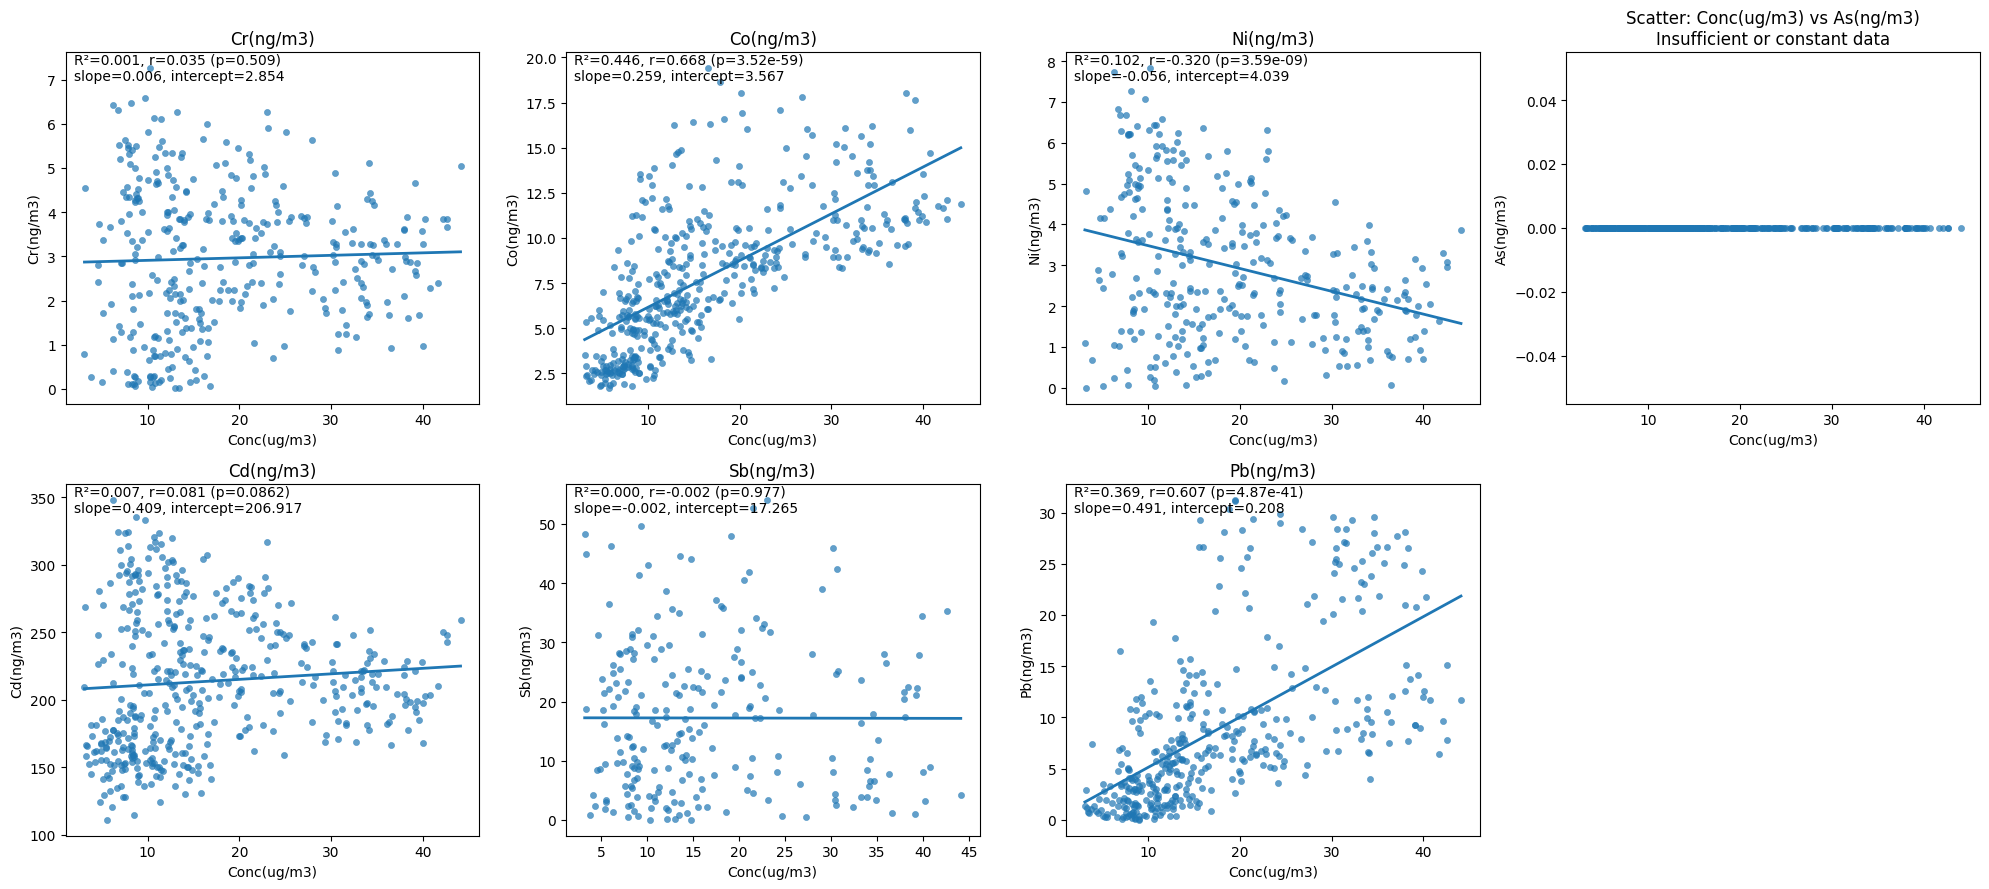

In [19]:
# 서브플롯 배치: 금속 개수에 맞춰 자동 계산
n = len(ycols)
ncols = 4
nrows = math.ceil(n / ncols)
fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4.5*nrows))
axes = np.atleast_1d(axes).ravel()

# 금속별 산점도 생성
for i, metal in enumerate(ycols):
    plot_scatter_with_regression(xcol, metal, df, axes[i])

# 없는 축 숨기기
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()